In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy.io import fits

In [3]:
exponential_profile   = fits.getdata("output/exponential_profile_poisson_noise1.fits")


In [4]:
flatcor_g = fits.getdata("flats/flatcor_g_53.fits")

<matplotlib.colorbar.Colorbar instance at 0x47eb488>

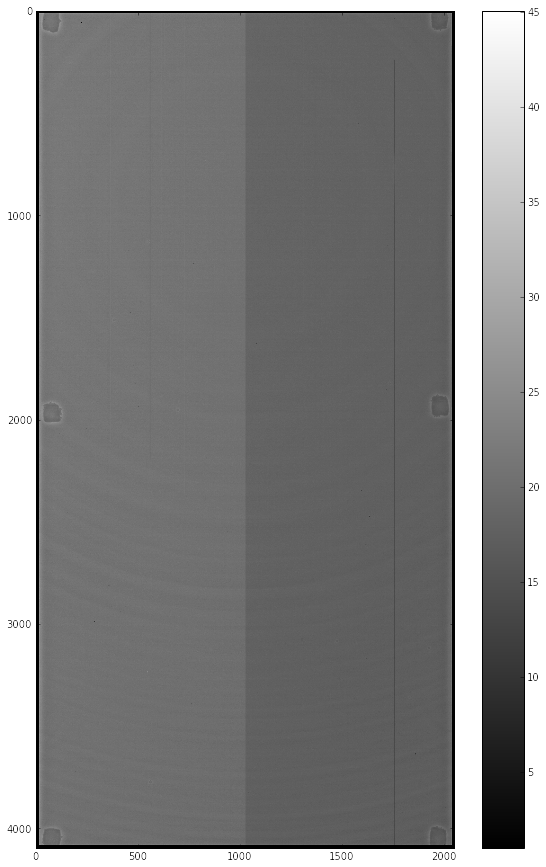

In [5]:
fig = figure(figsize=(10,15))
imshow(20**flatcor_g, cmap="gray")
colorbar()

In [6]:
x0 = 1000.
y0 = 944


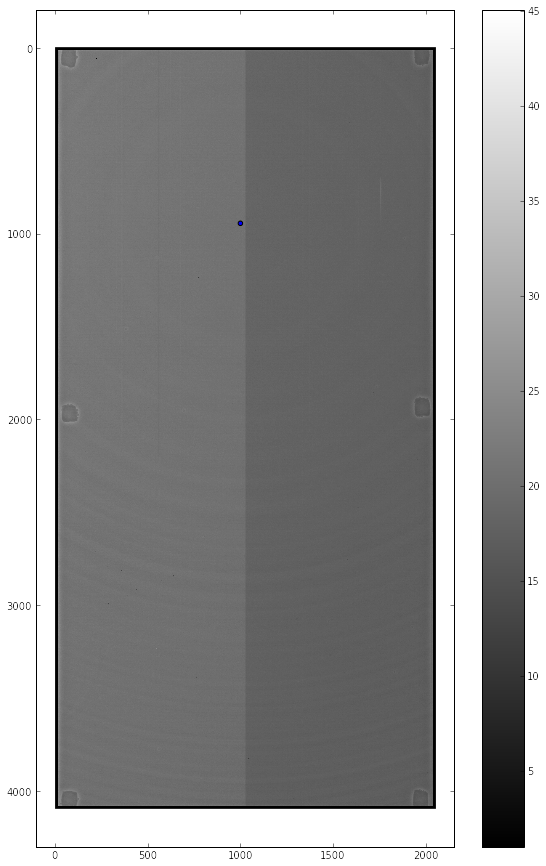

In [7]:
fig = figure(figsize=(10,15))
imshow(20**flatcor_g, cmap="gray")
colorbar()
scatter(x0,y0)

In [8]:
t = linspace(0,2*pi,100)
R = 1000
X = R*sin(t)+x0
Y = R*cos(t)+y0

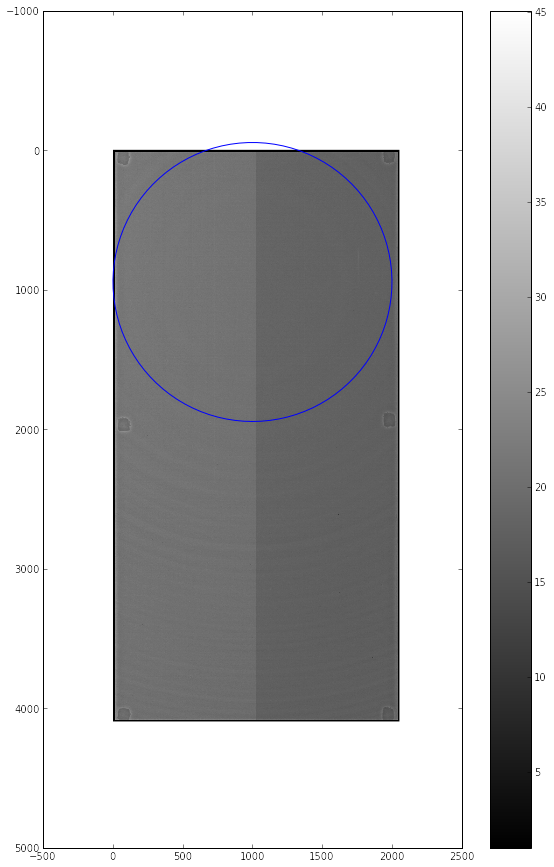

In [10]:
fig = figure(figsize=(10,15))
imshow(20**flatcor_g, cmap="gray")
colorbar()
plot(X,Y)

In [12]:
# X lim
a = 1024
b = 1980

# Y lim
c = 30
d = 4066

reduced_g53 = ones([d-c, b-a])



(4036, 956)


<matplotlib.colorbar.Colorbar instance at 0x799d488>

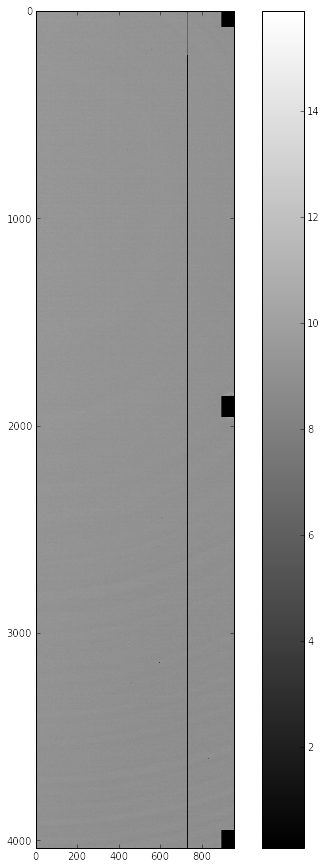

In [183]:
for i in range(d-c):
    for j in range(b-a):
        reduced_g53[i,j] = flatcor_g[i+c, j+a]
        
        if (j > 890) & (i < 80):
            reduced_g53[i,j] = -1
        if (j > 890) & (i > 3950):
            reduced_g53[i,j] = -1
        if (j > 890) & (i>1860) & (i<1960):
            reduced_g53[i,j] = -1
        if  (j == 1752-1024):
            reduced_g53[:,j] = -1

fig = figure(figsize=(10,15))
imshow(10**reduced_g53, cmap="gray")
print reduced_g53.shape
colorbar()

In [29]:
index = where (reduced_g53 ==0)

In [30]:
index[0].shape

(3825,)

In [37]:
def likelihood(X,Y,x0,y0,r0):
    chi2 = 0
    for i in range(X.size):
        aux = abs( (X[i]-x0)**2 + (Y[i]-y0)**2 -r0**2 )
        #print aux
        chi2 += aux
    return exp(-chi2), chi2

In [111]:
def MCMC(A):
    data = np.loadtxt("circlepoints.txt", delimiter=",")

    x0 = 969.5
    y0 = 937.6


    if A == 1:
        r0 = 635.
    if A == 2:
        r0 = 1500.
    if A == 3:
        r0 = 3000.

    X = data[range(11*(A-1),A*11),0]
    Y = data[range(11*(A-1),A*11),1]




    L = likelihood(X,Y,x0,y0,r0)


    #rint L

    MCsteps = 5000
    MCMC_steps = []

    #print L[1]
    for step in range(MCsteps):
        x0_new = np.random.normal(x0,1.)
        y0_new = np.random.normal(y0,1.)
        r0_new = np.random.normal(r0,10)

        L_new = likelihood(X,Y,x0_new,y0_new,r0_new)

        if ( L_new[1]/L[1] <=1 ):
            x0 = x0_new
            y0 = y0_new
            r0 = r0_new
            L  = L_new
        else:
            p = random.rand(1)[0]
            if ( exp( - L_new[1]+L[1] )> p):
                x0 = x0_new
                y0 = y0_new
                r0 = r0_new
                L  = L_new

        MCMC_steps.append([x0,y0,r0,L[1]])

        #print L
        #if (step%10000==0):
            #print step

    MCMC_steps = array(MCMC_steps); X_walk = MCMC_steps[:,0]; Y_walk = MCMC_steps[:,1]; R_walk = MCMC_steps[:,2]; L_walk = MCMC_steps[:,3]


    #plot(L_walk); yscale('log'); ylabel(r'$\chi^2$'); xlabel('Steps')

    index = where(L_walk == min(L_walk))
    return X_walk[index][0] - a, Y_walk[index][0] - c, R_walk[index][0]


In [112]:
MCMC(1)

(-53.819736321602363, 907.31986984293167, 635.08831648787191)

In [113]:
MCMC(2)

(-15.488640774154078, 883.54808589982554, 1582.4780946456722)

In [114]:
MCMC(3)

(-0.18907038631562045, 915.13775289162959, 2916.3161209624873)

In [147]:
x0, y0, R = MCMC(1)
I = array(range(reduced_g53.shape[0]))
J = array(range(reduced_g53.shape[1]))

R_min = 1000
R_max = 1100

In [129]:
Distances = np.zeros(reduced_g53.shape)
for i in I:
    for j in J:
        Distances[i,j]= ( (j-x0)**2 + (i-y0)**2  )**0.5

In [194]:
N = 200
R_bins = linspace( 50, 3500, N+1)
R_BIN = linspace( 50, 3500, N)
Radial_Profile = np.zeros(N)
for i in range(R_bins.size -1):
    index_i, index_j = where( (Distances> R_bins[i])& (Distances<R_bins[i+1]) & (reduced_g53!=-1) )
    Radial_Profile[i] = average(reduced_g53[index_i, index_j])

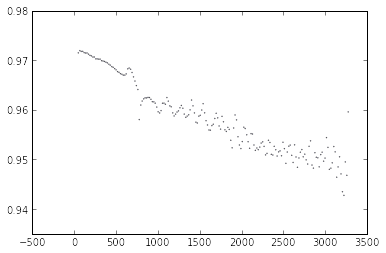

In [196]:
scatter( R_BIN, Radial_Profile, s = 0.1)

In [211]:

def Radial_Pro( A ):
    x0, y0, R = MCMC(A)
    I = array(range(reduced_g53.shape[0]))
    J = array(range(reduced_g53.shape[1]))

    Distances = np.zeros(reduced_g53.shape)
    for i in I:
        for j in J:
            Distances[i,j]= ( (j-x0)**2 + (i-y0)**2  )**0.5

    N = 200
    R_bins = linspace( 50, 3500, N+1)
    R_BIN = linspace( 50, 3500, N)
    Radial_Profile = np.zeros(N)
    for i in range(R_bins.size -1):
        index_i, index_j = where( (Distances> R_bins[i])& (Distances<R_bins[i+1]) & (reduced_g53!=-1) )
        Radial_Profile[i] = average(reduced_g53[index_i, index_j])

    scatter( R_BIN, Radial_Profile, s = 0.1)
    return Radial_Profile

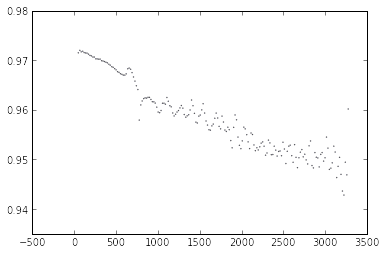

In [212]:
R1 = Radial_Pro(1)

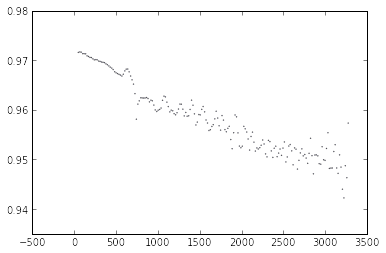

In [213]:
R2 = Radial_Pro(2)

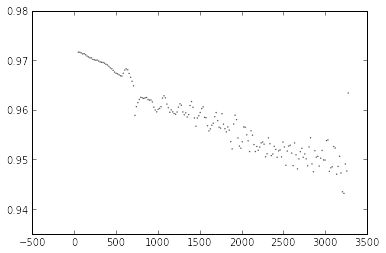

In [214]:
R3 = Radial_Pro(3)

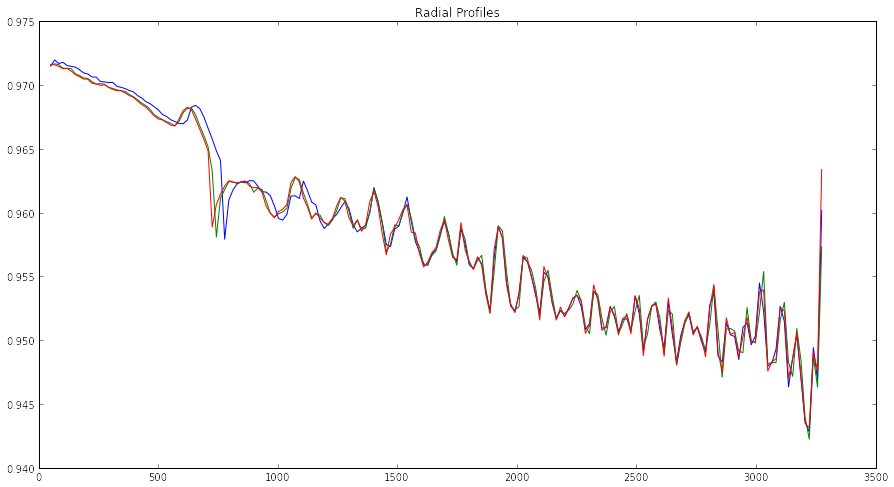

In [232]:
fig = figure(figsize=(15,8))



plot( R_BIN, R1)
plot( R_BIN, R2)
plot( R_BIN, R3)

plt.title("Radial Profiles")